# Transfer Learning
In the case of Image Recognition, it is rare to see models trained from scratch each time , due to the lack of sufficient data and  time needed to train. Transfer learning addresses this issue by leveraging the knowledge gained while solving one problem and applying it to a different but related problem.[1] For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks. Large datasets like ImageNet with 1.2 million images of 1000 labelled categories, form the base for learning.

ConvNets(Convolutional Neural Network) like VGG16, AlexNet etc which are pre-trained on ImageNet can be used as feature extractor.Since the models take 2-3 weeks to train, the final checkpoints from training are then used to fine-tune networks or in other related domain. This is why Transfer Learning is so powerful and provides efficiency for models to learn from  pre-trained models.

In this notebook , we will look a basic steps needed to do transfer learning using  VGG16 and apply the learning on new datasets.

## VGGNet Architecture

VGGNet has 5 layers of convolutional and pooling, followed by 3 fully connected layers and finally the softmax layer.Like the diagram below, we start with a 224x224x3 image and after the 5 conv/pooling layers we arrive at 7x7x512. After applying non-linearity in the first fully connected layer we have 4096 units. This is a data taken to re-train and build our own classifier on the new training data(i.e we are replacing the final fully connected layer). VGGNet is leveraged as a feature extractor and we are building a final classifier on top of it.

<img src="images/VGG16.png" width=700px>

## VGG 16 Parameters
Retrieve the parameters from the pre-trained VGG model from  https://github.com/machrisaa/tensorflow-vgg. 

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. 

In [4]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


## Flower power

Here we'll be using VGGNet to classify images of flowers.  This dataset comes from the [TensorFlow inception tutorial](https://www.tensorflow.org/tutorials/image_retraining)


In [5]:
import tarfile

dataset_folder_path = 'flower_photos'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [6]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [7]:
#Check if sub-directory has images on certain class and include those valid ones as classes
data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]
print(classes)

['daisy', 'dandelion', 'roses', 'sunflowers', 'test', 'tulips']


In [ ]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 10
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    
    with tf.Session() as sess:
        vgg = vgg16.Vgg16()
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        with tf.name_scope("content_vgg"):
            vgg.build(input_)

    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                
                # TODO: Get the values from the relu6 layer of the VGG network
                feed_dict = {input_: images}
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

In [ ]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. 

In [9]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader]).squeeze()
    print(labels.shape)
    
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))
    print(codes.shape)

(3670,)
(3670, 4096)


In [10]:
#One hot encoding of the labels
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(labels)
labels_vecs = lb.transform(labels)
labels_vecs.shape

(3670, 5)

# Data Preparation - Training/Validation/Testing

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
ss= StratifiedShuffleSplit(n_splits=1, test_size=0.2)
train_idx,val_idx = next(ss.split(codes,labels))

val_boundary = int(len(val_idx)/2)

test_idx = val_idx[val_boundary:,]
val_idx = val_idx[:val_boundary,]

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]


In [12]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)


## Classifier layer

Build a classfier from fully connected layers using codes as the inputs and the image labels as targets


In [13]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

fc = tf.contrib.layers.fully_connected(inputs_, 256)
    
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy)

optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [14]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

## Training and Validation

In [15]:
epochs = 10
iteration = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 5 == 0:
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/flowers.ckpt")

Epoch: 1/10 Iteration: 0 Training loss: 6.36665
Epoch: 1/10 Iteration: 1 Training loss: 16.45718
Epoch: 1/10 Iteration: 2 Training loss: 19.68351
Epoch: 1/10 Iteration: 3 Training loss: 17.18102
Epoch: 1/10 Iteration: 4 Training loss: 13.06906
Epoch: 0/10 Iteration: 5 Validation Acc: 0.5831
Epoch: 1/10 Iteration: 5 Training loss: 8.12081
Epoch: 1/10 Iteration: 6 Training loss: 6.60627
Epoch: 1/10 Iteration: 7 Training loss: 4.23111
Epoch: 1/10 Iteration: 8 Training loss: 2.90161
Epoch: 1/10 Iteration: 9 Training loss: 1.79277
Epoch: 0/10 Iteration: 10 Validation Acc: 0.7139
Epoch: 2/10 Iteration: 10 Training loss: 1.05991
Epoch: 2/10 Iteration: 11 Training loss: 2.15302
Epoch: 2/10 Iteration: 12 Training loss: 1.86850
Epoch: 2/10 Iteration: 13 Training loss: 1.85332
Epoch: 2/10 Iteration: 14 Training loss: 1.55502
Epoch: 1/10 Iteration: 15 Validation Acc: 0.7820
Epoch: 2/10 Iteration: 15 Training loss: 0.87410
Epoch: 2/10 Iteration: 16 Training loss: 0.52881
Epoch: 2/10 Iteration: 17 T

## Testing

In [16]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

Test accuracy: 0.8583


## Plotting image output

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

### Lets pick a random image from the internet and test to see the results 

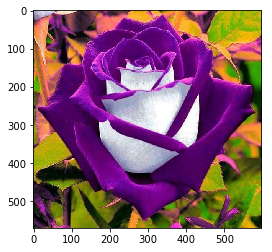

In [29]:
#test_img_path = 'flower_photos/roses/10894627425_ec76bbc757_n.jpg'
#test_img_path = 'flower_photos/test/tulip.jpg'
test_img_path = 'flower_photos/test/rosepurple.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

## Transfer learning - See the magic happen
Once you have a new test data, build the vgg model if the model is not in memory. Otherwise, just pick the output of the fully connected layer(relu6). Use the code as input into the classifier build and find the predicted output.

In [30]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)
        
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

"vgg" object already exists.  Will not create again.


[  1.01192388e-09   3.36035555e-09   9.96774137e-01   1.13529914e-05
   3.21449293e-03]


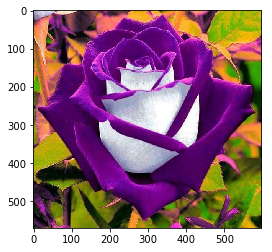

In [36]:
plt.imshow(test_img)
print(prediction)


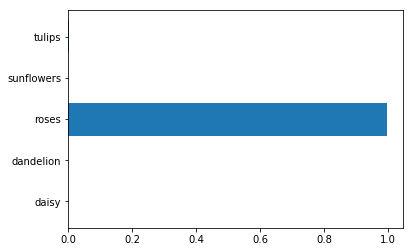

In [37]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)

Most of the code used in the notebook is what i used as part of the Udacity Deep Learning Nanodegree Foundation Course. (https://www.udacity.com/course/deep-learning-nanodegree-foundation--nd101)